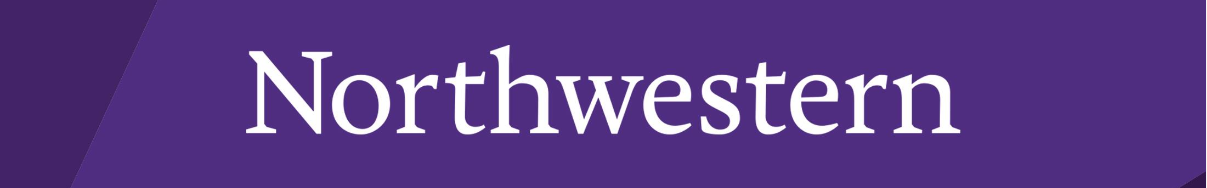

# Chest Xray - Image Captioning - Simple Encoder Decoder Model

##Import packages

In [1]:
#Ignore Warning
import warnings
warnings.filterwarnings("ignore") 
# set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import datetime
from packaging import version
import tarfile
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import os # Operation System
from tqdm import tqdm
import re
from PIL import Image
import pickle

from timeit import default_timer as timer
import time
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization,Input,Concatenate,Embedding,LSTM,Dense,Add,BatchNormalization,Dropout,Flatten
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

import nltk
from nltk.translate.bleu_score import sentence_bleu #bleu score

from tensorflow.keras.applications import VGG19, VGG16


## Verify TensorFlow version and Keras version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print("Keras version: ", keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.2
Keras version:  2.8.0


## Mount Google Drive to Colab environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd /content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/
!pwd
#!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/"

/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4
/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4
Working Directory
/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4


In [6]:
train_data = pd.read_pickle(work_dir + 'data/train.pkl')
test_data = pd.read_pickle(work_dir + 'data/test.pkl')
val_data = pd.read_pickle(work_dir + 'data/val.pkl')


In [7]:
train_data.shape

(3605, 8)

In [8]:
test_data.shape

(563, 8)

In [9]:
val_data.shape

(471, 8)

In [10]:
train_data.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,no acute cardiopulmonary findings .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,11.xml,<CLS> no acute cardiopulmonary findings . <END>,<CLS> no acute cardiopulmonary findings .,no acute cardiopulmonary findings . <END>,162
1,no acute cardiopulmonary abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,324.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
2,no acute cardiopulmonary abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,504.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
3,no acute cardiopulmonary abnormalities .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2539.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134
4,no acute cardiopulmonary disease .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2061.xml,<CLS> no acute cardiopulmonary disease . <END>,<CLS> no acute cardiopulmonary disease .,no acute cardiopulmonary disease . <END>,136


In [11]:
test_data.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,no acute radiographic cardiopulmonary process .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,356.xml,<CLS> no acute radiographic cardiopulmonary pr...,<CLS> no acute radiographic cardiopulmonary pr...,no acute radiographic cardiopulmonary process ...,83
1,no acute cardiopulmonary abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2290.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
2,no acute pulmonary disease .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2979.xml,<CLS> no acute pulmonary disease . <END>,<CLS> no acute pulmonary disease .,no acute pulmonary disease . <END>,58
3,no acute findings,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,1531.xml,<CLS> no acute findings <END>,<CLS> no acute findings,no acute findings <END>,30
4,negative for acute abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,1347.xml,<CLS> negative for acute abnormality . <END>,<CLS> negative for acute abnormality .,negative for acute abnormality . <END>,30


In [12]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train_data.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train_data.impression_final) 
test_captions = tokenizer.texts_to_sequences(test_data.impression_final) 
val_captions = tokenizer.texts_to_sequences(val_data.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <start>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression for faster training.'
%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader


The max and min value of "caption length" was found to be 135 and 3 respectively
The 80 percentile value of caption_len which is 30 will be taken as the maximum padded value for each impression for faster training.


##Model

In [13]:
resnet_model = keras.applications.resnet50.ResNet50(include_top=True)
resnet_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer('avg_pool').output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [16]:
import imgaug.augmenters as iaa

In [17]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [18]:
input_size = (224,224)

train_dataloader = Dataset(train_data,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test_data,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

val_dataloader = Dataset(val_data,input_size)
val_dataloader = Dataloader(val_dataloader,batch_size = batch_size)



##Resnet50 Model

In [19]:
# Instantiating ResNet50 model
resnet_base = keras.applications.resnet50.ResNet50(input_shape = (224, 224, 3), 
                              include_top = True, 
                              weights = 'imagenet')

In [20]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [21]:
def create_resnet():
  resnet_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
      input_tensor=Input(shape=(224, 224, 3)))

  outputs = resnet_model.output
  outputs = Flatten(name="flatten")(outputs)
  outputs = Dropout(0.5)(outputs)
  outputs = Dense(2, activation="softmax")(outputs)

  model = Model(inputs=resnet_model.input, outputs=outputs)

  #model = tf.keras.Model(inputs = model.input,outputs = model.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  

  for layer in resnet_model.layers:
      layer.trainable = False

  model.compile(
          loss='categorical_crossentropy', 
          optimizer='adam', 
          metrics=['accuracy']
  )
  model.summary()
  return model

In [22]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.resnet = create_resnet()
    self.resnet.summary()
    
    self.resnet.trainable = False

    #self.chexnet = create_chexnet()
    #self.chexnet.trainable = False
    #self.avgpool = tf.keras.layers.AveragePooling2D()
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.resnet(data) #op shape: (None,7,7,1024)
    #op = self.avgpool(op) #op shape (None,3,3,1024)
    #op = tf.reshape(op,shape = (-1,op.shape[1]*op.shape[2],op.shape[3])) #op shape: (None,9,1024)
    return op 

# Simple Encoder Decoder Model

In [23]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [24]:
glove = {}
with open(work_dir +'glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [25]:
 
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))




img_encoder = Image_encoder() #contains chexnet model which is set trainable  =  False
# img2_encoder = Image_encoder() #opshape: (?,1024)
bk_feat1 = img_encoder(image1)
# bk_dense = Dense(dense_dim,
#                  activation = 'relu',
#                  name = 'bk_dense'
#                   )
# bk_feat1 = bk_dense(bk_feat1) #dense for the first image op: (?,dense_dim)

bk_feat2 = img_encoder(image2)
# bk_feat2 = bk_dense(bk_feat2) #dense for the 2nd image op: (?,dense_dim)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)
bk_features_concat = BatchNormalization()(bk_features_concat) #applying batch norm
bk_features_concat = Dropout(dropout_rate)(bk_features_concat) 
image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )

                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)



embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)






lstm_layer =  LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

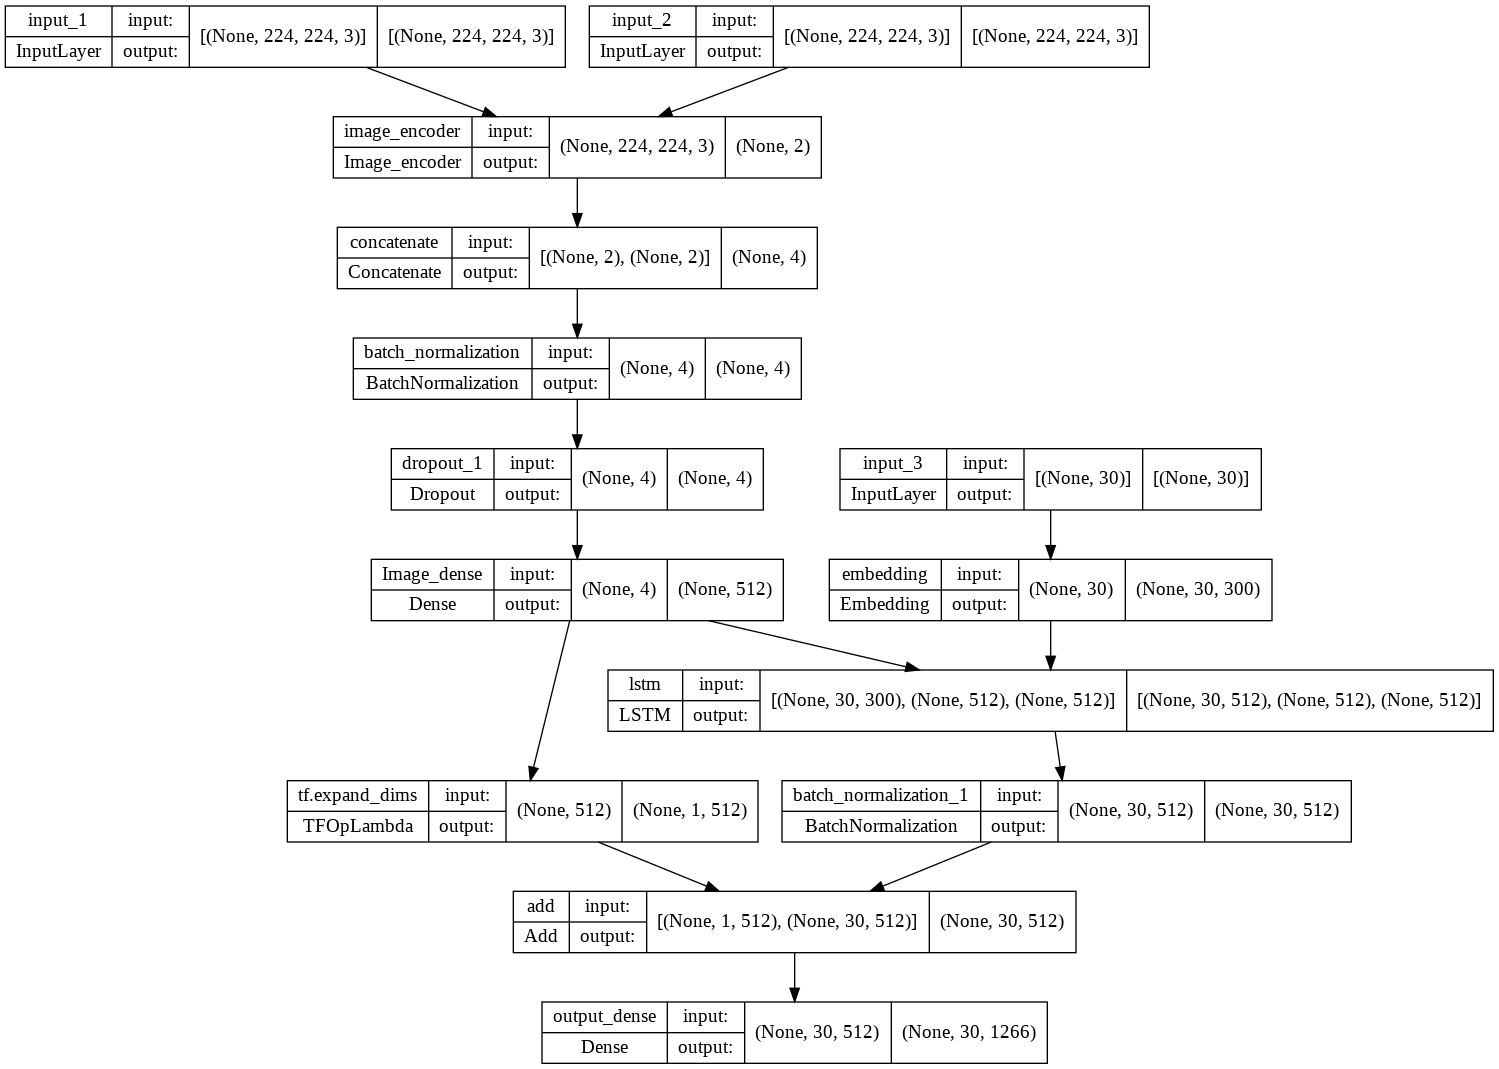

In [26]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [27]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [28]:
tf.keras.backend.clear_session()
tb_filename = 'Simple_Encoder_Decoder_Resnet/'
tb_file = os.path.join(work_dir,tb_filename)
model_filename = 'Simple_Encoder_Decoder_Resnet.h5'
model_save = os.path.join(work_dir,model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                    verbose = 2
                                    ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                      save_best_only = True,
                                      save_weights_only = True,
                                      verbose = 2
                                      ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                  log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                  
] #from keras documentation

In [29]:

history = model.fit(train_dataloader,
          validation_data = val_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          ) 

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.2600
Epoch 1: val_loss improved from inf to 1.25835, saving model to /content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/Simple_Encoder_Decoder_Resnet.h5
36/36 [==============================] - 112s 3s/step - loss: 0.8126 - accuracy: 0.2600 - val_loss: 1.2583 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.4159
Epoch 2: val_loss improved from 1.25835 to 1.17147, saving model to /content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/Simple_Encoder_Decoder_Resnet.h5
36/36 [==============================] - 93s 3s/step - loss: 0.4798 - accuracy: 0.4159 - val_loss: 1.1715 - val_accuracy: 0.4296 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.5248
Epoch 3: val_loss improved from 1.17147 to 1.02117, saving model to /content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/Simple_Encoder

In [30]:
model_filename = 'Simple_Encoder_Decoder_Resnet.h5'
model_save = os.path.join(work_dir,model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

# Predictions on test data

In [31]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [32]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

# Greedy Search

In [33]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  # image1 = model.get_layer('bk_dense')(image1) #op from dense layer
  # image2 = model.get_layer('bk_dense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  # concat = model.get_layer('batch_normalization')(concat)
  # image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array


In [34]:
%%time
k=-1
image1,image2 = test_data['image_1'].iloc[k],test_data['image_2'].iloc[k]
print(greedy_search_predict(image1,image2,model=model))

no acute cardiopulmonary findings . no evidence of active or active .
CPU times: user 386 ms, sys: 3.98 ms, total: 390 ms
Wall time: 372 ms


In [35]:
%%time
_ = mean_bleu(test_data,greedy_search_predict)

CPU times: user 2min 50s, sys: 5.74 s, total: 2min 56s
Wall time: 2min 49s


In [36]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

In [37]:
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.236486,0.244975,0.296901,0.359168


# Evaluate and Predict using greedy search

In [38]:
%%time
test_data['bleu_1_gs'] = np.zeros(test_data.shape[0]) #greedy search
test_data['prediction_gs'] = np.zeros(test_data.shape[0]) #greedy search
for index,rows in test_data.iterrows():
  #greedy search
  predicted_text = greedy_search_predict(rows.image_1,rows.image_2,model1)
  test_data.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['impression'].split()]
  test_data.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))



CPU times: user 2min 50s, sys: 5.84 s, total: 2min 55s
Wall time: 2min 49s


In [39]:
test_data['prediction_gs'].value_counts()*100/test_data.shape[0] #greedy search

no acute cardiopulmonary findings . no evidence of active or active .    82.238011
no acute cardiopulmonary findings . no active or active .                17.761989
Name: prediction_gs, dtype: float64

In [40]:
def final_caption_pred(image1,image2,method = "greedy",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  
  return pred_caption

In [41]:
def inference(image1,image2,true_caption,model=model1,top_k = [3],image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
 

In [42]:
test_data.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts,bleu_1_gs,prediction_gs
0,no acute radiographic cardiopulmonary process .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,356.xml,<CLS> no acute radiographic cardiopulmonary pr...,<CLS> no acute radiographic cardiopulmonary pr...,no acute radiographic cardiopulmonary process ...,83,0.333333,no acute cardiopulmonary findings . no evidenc...
1,no acute cardiopulmonary abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2290.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367,0.333333,no acute cardiopulmonary findings . no evidenc...
2,no acute pulmonary disease .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,2979.xml,<CLS> no acute pulmonary disease . <END>,<CLS> no acute pulmonary disease .,no acute pulmonary disease . <END>,58,0.250000,no acute cardiopulmonary findings . no evidenc...
3,no acute findings,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,1531.xml,<CLS> no acute findings <END>,<CLS> no acute findings,no acute findings <END>,30,0.250000,no acute cardiopulmonary findings . no evidenc...
4,negative for acute abnormality .,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,1347.xml,<CLS> negative for acute abnormality . <END>,<CLS> negative for acute abnormality .,negative for acute abnormality . <END>,30,0.166667,no acute cardiopulmonary findings . no evidenc...


In [43]:
test_data.to_csv(work_dir+'/data/outmodel_vgg.csv')  

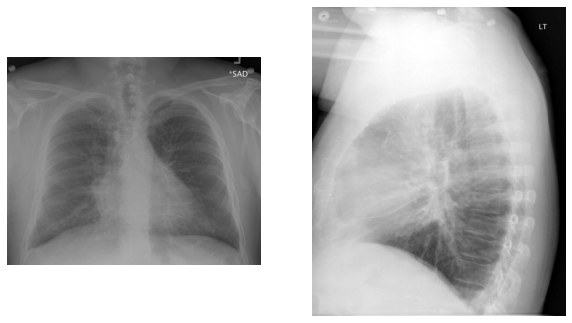


True caption: 'mild stable cardiomegaly without acute disease . possible right pleural effusion .'
Predicted caption(greedy search): 'no acute cardiopulmonary findings . no evidence of active or active .'


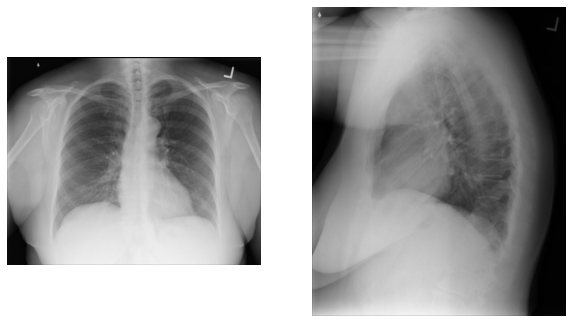


True caption: 'clear lungs . no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute cardiopulmonary findings . no evidence of active or active .'


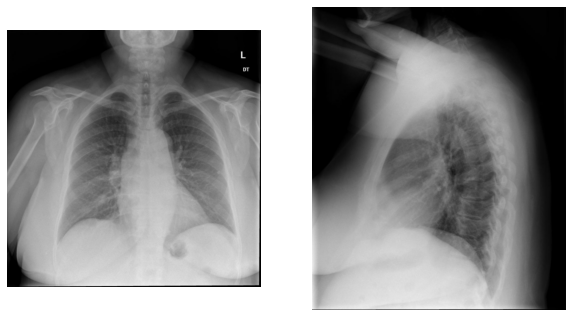


True caption: 'no acute cardiopulmonary findings .'
Predicted caption(greedy search): 'no acute cardiopulmonary findings . no evidence of active or active .'


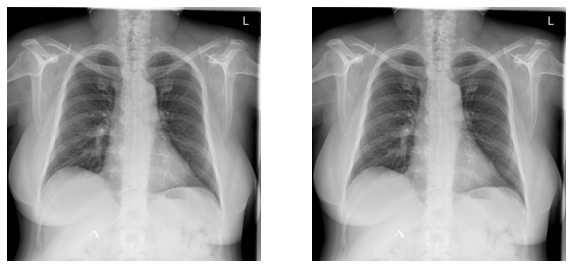


True caption: 'no acute cardiopulmonary findings .'
Predicted caption(greedy search): 'no acute cardiopulmonary findings . no evidence of active or active .'


In [44]:
i = test_data[test_data['bleu_1_gs']>0].sample(4).index
for k in i:
  image1,image2 = test_data['image_1'][k],test_data['image_2'][k]
  true_caption = test_data['impression'][k]
  inference(image1,image2,true_caption)

In [45]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [46]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

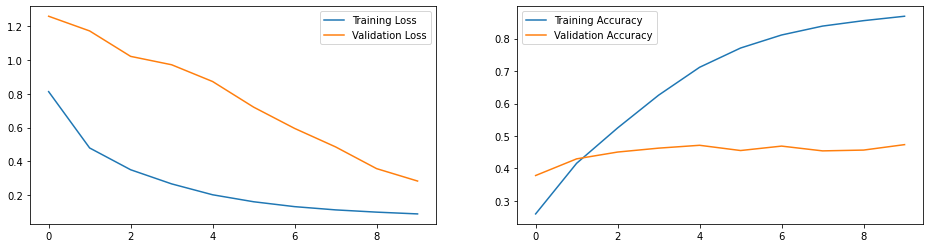

In [47]:
# Plot the training metrics
plot_history(history)